"""
Instructions:

Mouse anesthesia:
    - IP inject chlorprothixene (Sigma-Aldrich C1671-1G, 2 mg of chlorprothixene powder in 10 mL of 
      sterilized water, 0.1 mL/20 g per mouse)
    - Inhaled isoflurane at 0.5 percent concentration throughout the acquisition session. 
    
Imaging Parameters.
    - 2x2 acquisition at 20 Hz. Be sure to crop down field of view to just around the brain.
    - 700 nm light. 
    - 150 repeats of orientation (the third one)
    - Place tape over the mouses body to prevent whiskers and back from entering field of view. 
    
Processing.
    - Transfer to computer with a lot of RAM. 
    - Open the entire video in imagej, crop down, and scale down by 0.5 in x, y, and t. 
    - Save out as a tif (i.e. with name _scaled appended)
    - Add information to cosmos.params.intrinsic_imaging_params
    - Run this notebook (intrinsic_imaging_alignment.ipynb). 

Copy the final output (chunk2.tif, phase_2.png, and raw_img.png) into 
folder in Dropbox/cosmos/intrinsic_imaging_align/

"""

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os

from scipy.ndimage.filters import gaussian_filter1d, convolve1d, median_filter
from scipy.signal import butter, filtfilt, convolve, fftconvolve, medfilt
from matplotlib import pyplot as plt
from scipy.signal import correlate, savgol_filter
from matplotlib import patches
import scipy.ndimage as ni
import numpy as np
import pycircstat
import tifffile
import h5py
import skimage.io

import cosmos.traces.trace_analysis_utils as utils
import cosmos.params.intrinsic_imaging_params as params

/home/user/anaconda3/envs/cosmos3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load data

In [8]:
#### Set up params
dataid = 9 # See cosmos/params/intrinsic_imaging_params for corresponding datasets.
datainfo = params.DATASETS[dataid]

base = datainfo['base']
im_path = base + datainfo['im_path']
led_px = datainfo['led_px']
hz = datainfo['hz']
ndirs = datainfo['ndirs']
stim_length = datainfo['stim_length']
blank_length = datainfo['blank_length']
sd_thresh = datainfo['sd_thresh']
start_frame = datainfo['start_frame']
cull_first_pulse = datainfo['cull_first_pulse']
filter_data = datainfo['filter_data']

save_chunks = True
print(base)

/hdd1/Data/20190614/cux25456_bars8_700nm_iso0-5_20hz_150trials_grating10_blank1_1-1_scaled/


In [9]:
# Load the data
import time

t0 = time.time()
with tifffile.TiffFile(im_path) as tif:
    stack = tif.asarray()

stack = stack[start_frame:, :, :]
print(time.time() - t0)

11.639012098312378


### Process data

In [10]:
# TODO: Include imagej macros for the scaling part etc...

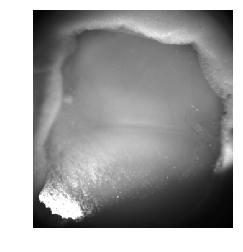

In [11]:
# Save out a raw image
path = base + '/raw_img'
plt.figure()
im = stack[int(stack.shape[0]/2), :,:]
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig(path+'.png')

skimage.io.imsave(path+'.tif', im)

In [12]:
path

'/hdd1/Data/20190614/cux25456_bars8_700nm_iso0-5_20hz_150trials_grating10_blank1_1-1_scaled//raw_img'

[110 111]


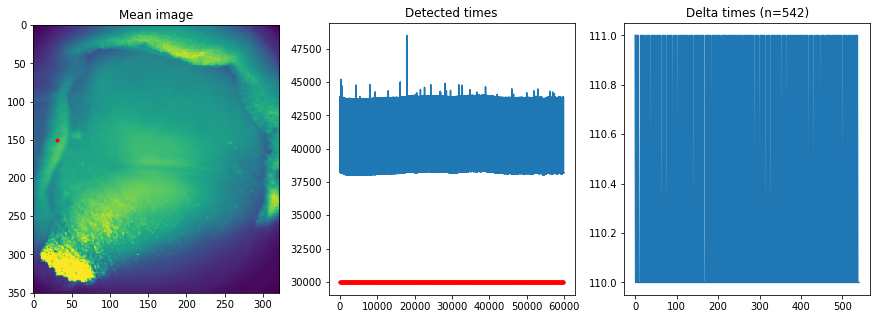

In [13]:
plt.figure(figsize=(15, 5))

# Plot mean image of the movie
plt.subplot(1,3,1)
plt.title('Mean image')
plt.imshow(np.mean(stack, 0))
plt.plot(led_px[1], led_px[0], 'r.')

# Get LED trigger times
led_trace = np.mean(np.mean(stack[:, led_px[0]-18:led_px[0]+18, led_px[1]-18:led_px[1]+18], 2), 1)
dt = np.diff(led_trace)
led_times = np.where(dt > np.mean(dt)+sd_thresh*np.std(dt))[0]
led_times = np.delete(led_times, np.where(np.diff(led_times) < hz*(stim_length+blank_length)-10)[0])
led_times = led_times + 1

plt.subplot(1,3,2)
plt.title('Detected times')
plt.plot(led_trace) 
plt.plot(led_times, [np.mean(led_times)]*len(led_times), 'r.')

# Get rid of the first time if desired
if cull_first_pulse:
    led_times = led_times[1:]

plt.subplot(1,3,3)
plt.title('Delta times (n=' + str(len(led_times)) + ')')
print(np.unique(np.diff(led_times)))
plt.plot(np.diff(led_times))

542


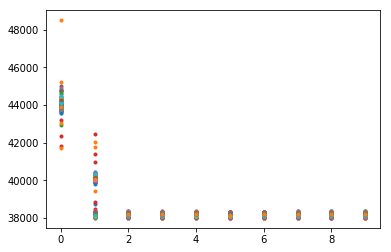

In [16]:
# Can we see the LED peaks all centered at zero?
print(len(led_times))
for led_time in led_times:
    plt.plot(led_trace[led_time:led_time+10], '.')

In [17]:
# how long was each trial block in seconds
trial_nframes = int(np.median(np.diff(led_times)))
trial_nframes/hz

11.0

In [18]:
# Load the data
raw_stack = stack

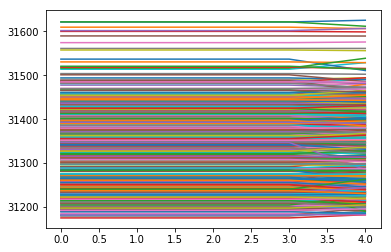

In [19]:
# Zero out LED frames
for time in led_times:
    raw_stack[time-2:time+3, :, :] = raw_stack[time-3, :, :]
    plt.plot(np.mean(np.mean(raw_stack[time-1:time+4, :, :], 1), 1))

In [20]:
ndirs

4

In [21]:
### Assign trials to each trial-type
trials = []

if ndirs == 4:
    ntr = 149
    trials.append(np.arange(0,ntr ))
    trials.append(np.arange(ntr,ntr*2 ))
    trials.append(np.arange(ntr*2,ntr*3))
    trials.append(np.arange(ntr*3,ntr*4-1))
else:
    ntr = 190
    trials.append(np.arange(0,ntr ))


In [22]:
# Save out all trials in one chunk
if 0:
    path = base + '/chunk_all_2.tif'.format(ind)
    with tifffile.TiffWriter(path, bigtiff=True) as tif:
        chunk = raw_stack[led_times[310]:led_times[440],:,:]
        for idx in range(np.shape(chunk)[0]):
            tif.save(chunk[idx, :, :])

In [23]:
### Optionally TODO: only use frames where the mouse was not moving (as determined by central sinus signal)
### May want to include info about coordinates in the dataset struct. 
movement_trials = []

In [24]:
### Extract trials for each orientation and save out averaged video. Takes a little time.
chunks = []
for ind, chunk_trials in enumerate(trials):
    
    chunk = np.zeros((trial_nframes, raw_stack.shape[1], raw_stack.shape[2]))
    for tr in chunk_trials[:20]:
        if tr not in movement_trials:
            chunk += raw_stack[led_times[tr]:led_times[tr]+trial_nframes,:,:]
        
    chunk /= len(chunk_trials)
    chunk -= np.mean(chunk, axis=0)
    chunk = savgol_filter(chunk, 61, 3, axis=0)
    chunk = median_filter(chunk, (1, 3, 3))
    chunk = savgol_filter(chunk, 61, 3, axis=0)
    chunk -= np.mean(np.mean(chunk, axis=2), axis=1)[:, None, None]
    chunks.append(chunk)
    # Save out the filtered stack if desired
    if 1:
        path = base + '/chunk{}.tif'.format(ind)
        with tifffile.TiffWriter(path, bigtiff=True) as tif:
            for idx in range(np.shape(chunk)[0]):
                tif.save(chunk[idx, :, :])

In [25]:
### Now load chunks and process them into some form of reversal map.
### Can optionally just skip to this step if you have already computed the averaged chunks. 

import time
t0 = time.time()

chunks = []
for ind in range(4):
    path = base + '/chunk{}.tif'.format(ind)
    with tifffile.TiffFile(path) as tif:
        chunk = tif.asarray()

    chunks.append(chunk)
    print(time.time() - t0)



0.09492826461791992
0.157670259475708
0.21490812301635742
0.2696201801300049


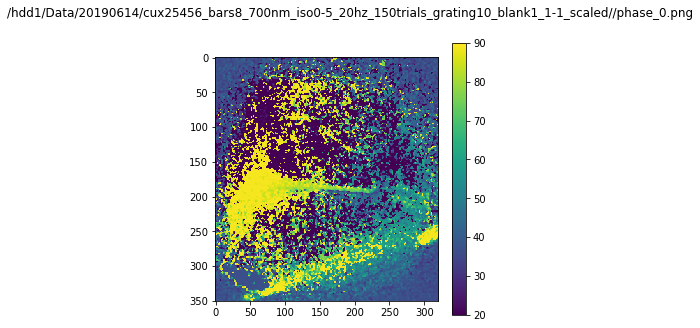

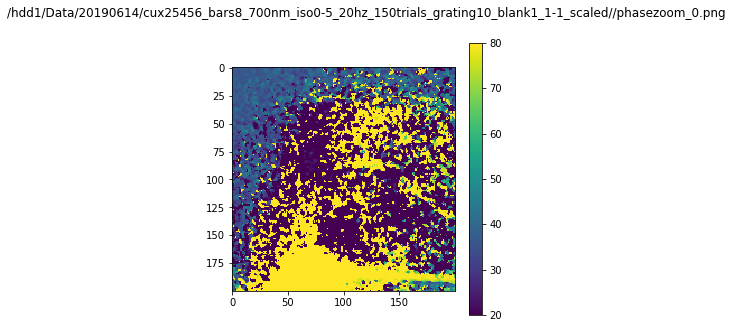

In [26]:
### Plot a phase map for alignment. 
# chunk = chunks[3]
chunkid = 0
chunk = chunks[chunkid]
# chunk = savgol_filter(chunk, 61, 3, axis=0)

plt.figure(figsize=(5, 5))
phase_map = np.argmin(chunk[10:-10,0:-1, 0:-1], axis=0)
pmap = medfilt(phase_map, 1)
plt.imshow(pmap)
plt.colorbar()
plt.clim([20, 90])
plt.suptitle(path)
impath = base + '/phase_{}.png'.format(chunkid)
plt.suptitle(impath)
plt.savefig(impath)

plt.figure(figsize=(5, 5))
plt.imshow(pmap[0:200,0:200])
plt.colorbar()
plt.clim([20, 80])
impath = base + '/phasezoom_{}.png'.format(chunkid)
plt.suptitle(impath)
plt.savefig(impath)


In [23]:
chunkid

0